# Combining PCA and GMM For Image Creation

This notebook demonstrates how to generate realistic face images by combining:
1. Principal Component Analysis (PCA) for dimensionality reduction
2. Gaussian Mixture Models (GMM) for learning the distribution of faces

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people

## Loading LFW Dataset

In [2]:
faces = fetch_lfw_people(min_faces_per_person=500)
print(faces.target_names)
print(faces.images.shape)

['George W Bush']
(530, 62, 47)


### Understanding Dataset Dimensions

`N` = The total number of images

In [3]:
N=faces.images.shape[0]
N

530

`M` = The number of elements in each input sample.

In [4]:
#what is M?
M=faces.images.shape[1]*faces.images.shape[2]
M

2914

Next let's plot the first 100 of these to recall exactly what we're looking at:

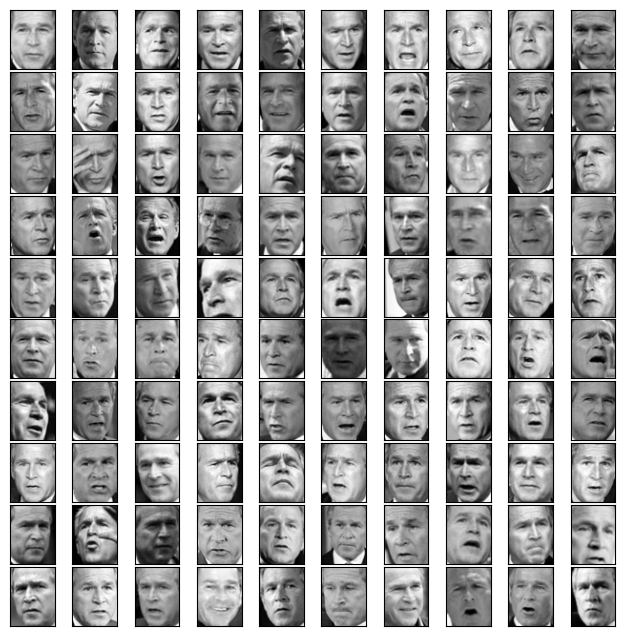

In [5]:
# Function for plotting faces
def plot_faces(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i], cmap='gray')
plot_faces(faces.images)

We have N images, and each image has M pixels <br>
N = 530  <  M = 2914 <br>
the number of samples is smaller than the dimension <br>
We will use dimension reduction to reduce the number of features

## Applying PCA for Dimension Reduction
 
We'll use PCA to:
 1. Reduce dimensions from 2914 to 120
 2. Keep the most important features
 3. Make the modeling problem tractable

In [6]:
pca = PCA(n_components=120, whiten=True)
data = pca.fit_transform(faces.images.reshape(N,-1))

In [7]:
#check the shape of data
data.shape

(530, 120)

In [8]:
#check the value of cumulative explained variance ratio using "n_components" eigenvectors/eigenvalues
pca.explained_variance_ratio_.sum()

0.9458593

## Gaussian Mixture Model Optimization
 
A GMM models the data as a mixture of several Gaussian distributions. We need to:
1. Determine the optimal number of components
2. Fit models with different numbers of components
3. Use AIC (Akaike Information Criterion) for model selection

### Understanding AIC (Akaike Information Criterion)

AIC is a mathematical method for model selection that helps us answer a crucial question: 
"How many Gaussian components should we use in our mixture model?"
 
The AIC score is calculated as:
```
AIC = 2K - 2ln(L)
```
Where:
- K = number of parameters in the model (model complexity)
- L = maximum likelihood of the model (how well it fits the data)
 
#### Why AIC Matters
 
AIC helps us balance two competing goals:
1. **Model Fit**: How well does the model describe our training data?
    - More components → Better fit
    - But too many components → Overfitting
 
2. **Model Simplicity**: How simple/complex is our model?
    - More components → More complex model
    - More complexity → Higher risk of overfitting
 
#### Interpreting AIC Scores
 
Lower AIC scores are better because:
 - The term `2K` penalizes model complexity
 - The term `-2ln(L)` rewards better fit to the data
 - The minimum AIC represents the best trade-off
 
#### In Face Generation Context
 
For our face generation task:
- Too few components: Generated faces look too similar
- Too many components: Model captures noise, not real patterns
- Optimal components: Captures true variety in face features

In [9]:
#fit GMM models with different number of components
n_components = np.arange(1, 100, 10)
gmm_models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]

### Model Selection Using AIC
 
For each number of components:
1. Fit a GMM model
2. Calculate AIC score
3. Track the best model found

In [10]:
#find the best n_components using AIC
aic_values = []

lowest_aic = np.infty
best_gmm = None
for gmm in gmm_models:
    gmm.fit(data)
    aic = gmm.bic(data)
    aic_values.append(aic)
    if aic < lowest_aic:
        aowest_bic = aic
        best_gmm = gmm

#fit GMM using the best n_components
best_gmm.fit(data)

GaussianMixture(n_components=91, random_state=0)

### Visualizing Model Selection Results
 
Plot AIC scores to understand:
- How model complexity affects fit
- Where the optimal number of components lies
- If we have a clear minimum

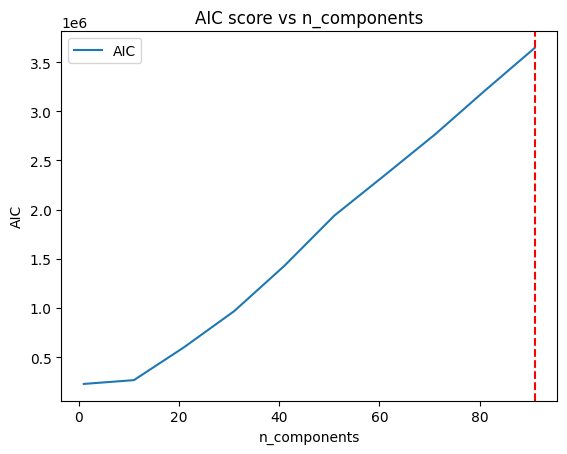

In [11]:
#plot the AIC score
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('AIC')
plt.title('AIC score vs n_components')
plt.axvline(best_gmm.n_components, color='red', linestyle='--')


The curve keeps going up: something is weird.

Let's check for convergence of the model.

In [12]:
# Check best model for convergence
best_gmm.converged_

True

The Model does seem to have converged, but perhaps it congerged on a local minma. Further Testing is Required

In [13]:
# Draw N samples from the GMM model
data_new = best_gmm.sample(N)
data_new = data_new[0]
data_new.shape

(530, 120)

### Preforming PCA Inverse Transform

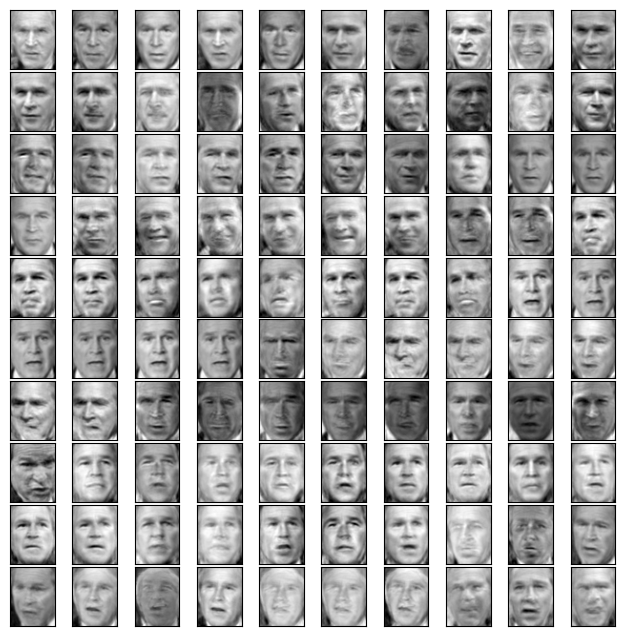

In [14]:
# Reconstruct the faces using the inverse PCA transformation
faces_new = pca.inverse_transform(data_new)
plot_faces(faces_new.reshape(-1,62, 47))

## Testing with Larger Dataset
 
Let's try with more data:
1. Reduce minimum faces per person to 50
2. Get more samples for better modeling
3. Maintain the same dimensionality reduction

In [15]:
faces = fetch_lfw_people(min_faces_per_person=50)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']
(1560, 62, 47)


In [16]:
#check the number of images
N=faces.images.shape[0]
N

1560

In [17]:
#check the input dimension (the number of elements in each input sample)
M=faces.images.shape[1]*faces.images.shape[2]
M

2914

We have N images, and each iamge has M pixels  <br>
N = 1560 and M = 2914 : N < M  <br>
We will use dimension reduction to reduce the number of features from 2914 to 120 <br>

### Applying PCA

In [18]:
pca = PCA(n_components=120, whiten=True)
data = pca.fit_transform(faces.images.reshape(N,-1))

In [19]:
#check the shape of data
data.shape

(1560, 120)

In [20]:
#check the value of cumulative explained variance ratio
pca.explained_variance_ratio_.sum()

0.91856754

### GMM Model Optimzation

Now, fit many GMMs to the transformed `data` with different number of components

We will select the best one based on AIC

In [21]:
#fit GMM with n_components in the range of 1 to 200 with the step of 10
n_components = np.arange(1, 200, 10)
gmm_models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]

In [22]:
aic_values = []

lowest_aic = np.infty
best_gmm = None
for gmm in gmm_models:
    gmm.fit(data)
    aic = gmm.aic(data)
    aic_values.append(aic)
    if aic < lowest_aic:
        lowest_aic = aic
        best_gmm = gmm

best_gmm.n_components

51

### Analyzing Model Selection Results
 
The AIC curve should now show a clear U-shape. 

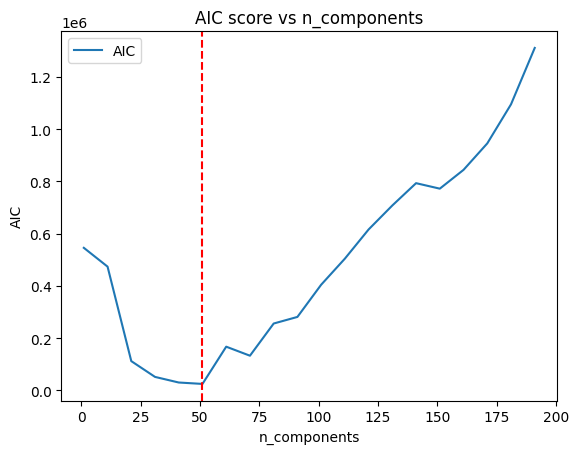

In [23]:
# Plot AIC score
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.ylabel('AIC')
plt.title('AIC score vs n_components')
plt.axvline(best_gmm.n_components, color='red', linestyle='--')

Now, we have a U-haped curve, nice. (again, you may get a different curve)

It appears that AIC is miminized around 60 components.


Let's quickly fit GMM with n_components=?? (when AIC is minimum) to the `data` and confirm that it has converged:

In [24]:
# fit the GMM with n_components = the value when AIC is minimum
best_gmm.fit(data)

GaussianMixture(n_components=51, random_state=0)

## Generating New Face Images
 
Now we can generate new faces by:
1. Sampling from our GMM model
2. Transforming back to image space using PCA
3. Visualizing the results

In [25]:
# Generate new samples using the GMM model
data_new = best_gmm.sample(N)
data_new = data_new[0]
data_new.shape

(1560, 120)

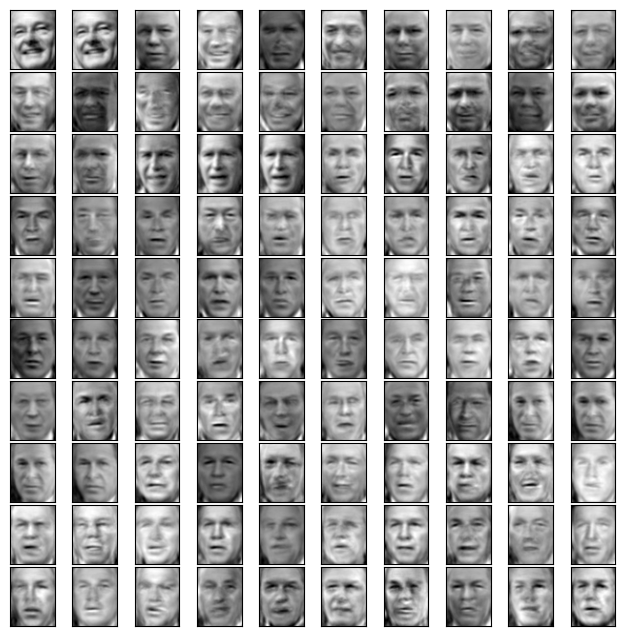

In [26]:
faces_new = pca.inverse_transform(data_new)
plot_faces(faces_new.reshape(-1,62, 47))

## Key findings:
1. PCA + GMM is an effective combination for face generation
2. Dimensionality reduction is crucial for model stability
3. Model selection via AIC helps find optimal complexity
4. Generated faces maintain key facial features while showing variation
 
Limitations:
1. Generated images can be blurry
2. Some artifacts in fine details
3. Computational intensity scales with data size
 
The combination of PCA and GMM provides a good balance between:
- Computational efficiency
- Model complexity
- Generation quality